In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# basic import
import os
import os.path as op
import sys
sys.path.insert(0, op.dirname(os.getcwd()))

# python libs
import numpy as np
import pandas as pd
import xarray as xr
from scipy.stats import linregress
from datetime import datetime

# tk libs
from lib.objs.tkpaths import Site
from lib.tides import Calculate_MMSL
from lib.statistical import runmean
from scipy.optimize import least_squares
from lib.plotting.tides import Plot_Tide_SLR, Plot_Tide_RUNM, Plot_Tide_MMSL


# --------------------------------------
# Site paths and parameters
site = Site('KWAJALEIN')
site.Summary()

# input files
p_mareografo_nc = site.pc.site.tds.mareografo_nc
p_sst_KMA = site.pc.site.sst.KMA
p_sst_PCs_sim = site.pc.site.sst.PCs_sim

# output files

# export figs
p_export_tds = site.pc.site.exp.tds

# parameters for mmsl calculation
mmsl_year_ini = int(site.params.TIDES.mmsl_year_ini)
mmsl_year_end = int(site.params.TIDES.mmsl_year_end)











Site Parameters
.params.ESTELA_KMA_RG.alpha................. 0.3
.params.ESTELA_KMA_RG.date_end.............. 2011-01-22
.params.ESTELA_KMA_RG.date_ini.............. 1979-01-22
.params.ESTELA_KMA_RG.num_clusters.......... 36
.params.MJO.alr_markov...................... 3
.params.MJO.alr_seasonality................. [2,4,8]
.params.SIMULATION.alr_covars_markov........ 1
.params.SIMULATION.alr_covars_seasonality... [2,4]
.params.SIMULATION.date_end................. 3020-01-01
.params.SIMULATION.date_ini................. 2020-01-01
.params.SLP.lat1............................ 60.5
.params.SLP.lat2............................ 0.5
.params.SLP.lon1............................ 115
.params.SLP.lon2............................ 279
.params.SLP.resample........................ 4
.params.SST_AWT.num_clusters................ 6
.params.SST_AWT.num_pcs_rnd................. 1000
.params.SST_AWT.pca_month_end............... 5
.params.SST_AWT.pca_month_ini............... 6
.params.SST_AWT.pca_y

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:8: FutureWarning: The inplace argument has been deprecated and will be removed in xarray 0.12.0.
  


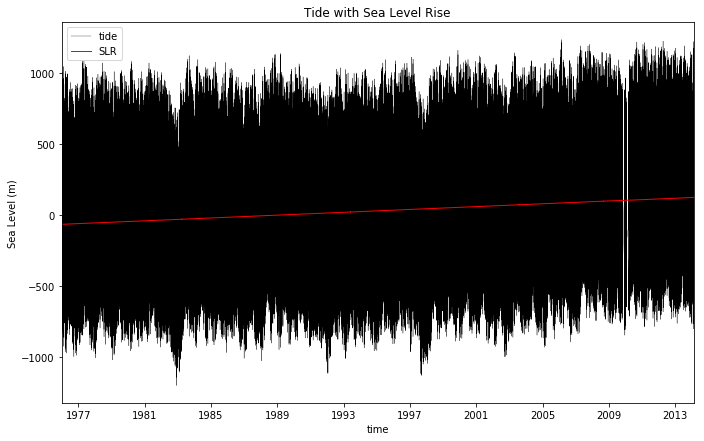

In [2]:
# --------------------------------------
# Load data from tide gauge
xds_tide = xr.open_dataset(p_mareografo_nc)

# fix data 
xds_tide.rename(
    {'WaterLevel':'tide'},
    inplace=True)
xds_tide['tide'] = xds_tide['tide']*1000


# calculate SLR using linear regression
time = np.array(range(len(xds_tide.time.values[:])))
tide = xds_tide.tide.values[:]

slope, intercept, r_value, p_value, std_err = linregress(time,tide)
slr = intercept + slope * time

# Plot tide with SLR
time = xds_tide.time.values[:]
Plot_Tide_SLR(time, tide, slr)


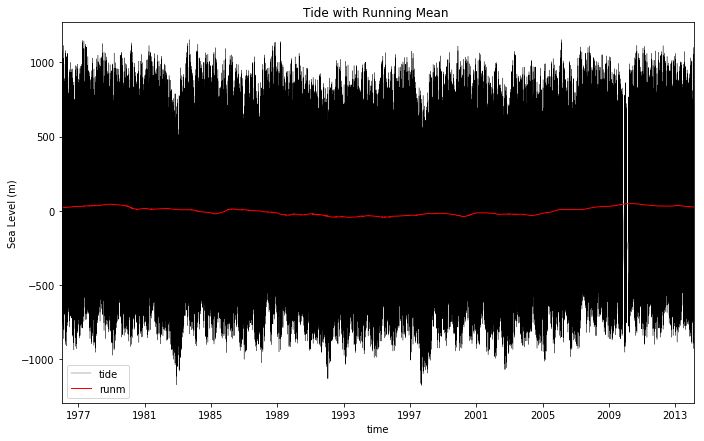

In [3]:
# --------------------------------------
# remove SLR and runmean from tide 
tide_noslr = tide - slr

# calculate tide running mean
time_window = 365*24*3
runm = runmean(tide_noslr, time_window, 'mean')

# remove running mean
tide_noslr_norunm = tide_noslr - runm

# Plot tide without SLR and runm
Plot_Tide_RUNM(time, tide_noslr, runm)



Calculating Monthly Mean Sea Level between 1996 and 2017...


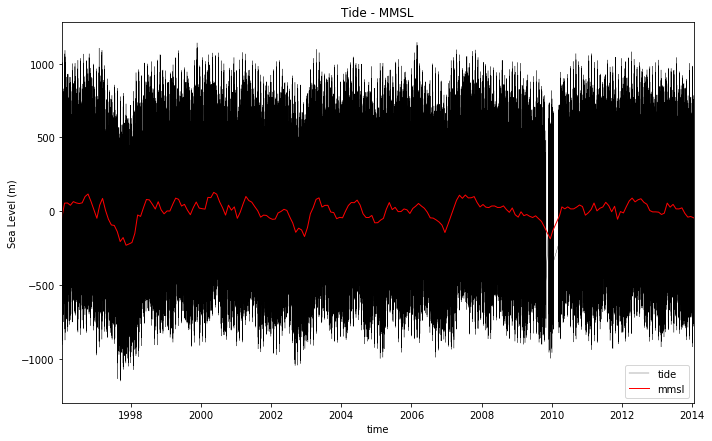

In [4]:
# --------------------------------------
# calculate Monthly Mean Sea Level (mmsl)
tide = tide_noslr_norunm

print('\nCalculating Monthly Mean Sea Level between {0} and {1}...'.format(
    mmsl_year_ini, mmsl_year_end
))
xds_tide['tide'].values = tide
xds_MMSL = Calculate_MMSL(xds_tide, mmsl_year_ini, mmsl_year_end)

# Plot tide and mmsl 
mmsl_time = xds_MMSL.time.values[:]
mmsl_tide = xds_MMSL.mmsl.values[:]
time = xds_tide.time.values[:]
Plot_Tide_MMSL(time, tide, mmsl_time, mmsl_tide)


In [ ]:
# --------------------------------------
# Load SST Anual Weather Types PCs
xds_KMA = xr.open_dataset(p_sst_KMA)

PCs = np.array(xds_KMA.PCs.values)
PC1 = PCs[:,0]
PC2 = PCs[:,1]
PC3 = PCs[:,2]
PCs_years = [pd.to_datetime(dt).year for dt in xds_KMA.time.values]

MMSL_time = xds_MMSL.time.values
MMSL = xds_MMSL.mmsl.values

# MMSL PCs calculations: cut and pad it to monthly resolution
# TODO: creo que esto se puede hacer en 1 linea de xarray
ntrs_m_mean = np.array([])
ntrs_time = []

MMSL_PC1 = np.array([])
MMSL_PC2 = np.array([])
MMSL_PC3 = np.array([])

for c, y in enumerate(PCs_years):
    pos = np.where(
        (MMSL_time >= np.datetime64('{0}-06-01'.format(y))) &
        (MMSL_time <= np.datetime64('{0}-05-29'.format(y+1)))
    )

    if pos[0].size:
        ntrs_m_mean = np.concatenate((ntrs_m_mean, MMSL[pos]),axis=0)
        # TODO check for 0s and nans in ntrs_m_mean?
        ntrs_time.append(MMSL_time[pos])

        MMSL_PC1 = np.concatenate((MMSL_PC1, np.ones(pos[0].size)*PC1[c]),axis=0)
        MMSL_PC2 = np.concatenate((MMSL_PC2, np.ones(pos[0].size)*PC2[c]),axis=0)
        MMSL_PC3 = np.concatenate((MMSL_PC3, np.ones(pos[0].size)*PC3[c]),axis=0)

ntrs_time = np.concatenate(ntrs_time)

In [ ]:
# --------------------------------------
# Fit non linear regression model
# TODO: COMENTAR CON ANA EL COMO METER EL TIEMPO EN LA FUNCION
# TODO: CREAR MODELO REGRESION LINEAL B1+B2X2+B3X3...
# ALIMENTARLO CON PC1,PC2,PC3
def modelfun(x, t, pc1, pc2, pc3):
    return x[0] + x[1]*pc1 + x[2]*pc2 + x[3]*pc3 + \
            (x[4] + x[5]*pc1 + x[6]*pc2 + x[7]*pc3) * np.cos(2*np.pi*t) + \
            (x[8] + x[9]*pc1 + x[10]*pc2 + x[11]*pc3) * np.sin(2*np.pi*t) + \
            (x[12] + x[13]*pc1 + x[14]*pc2 + x[15]*pc3) * np.cos(4*np.pi*t) + \
            (x[16] + x[17]*pc1 + x[18]*pc2 + x[19]*pc3) * np.sin(4*np.pi*t)

x0 = np.ones(20)
res_lsq = least_squares(fun, x0, args=(ntrs_time, MMSL_PC1, MMSL_PC2, MMSL_PC3))



# --------------------------------------
# TODO: PREDECIR 1000 YEARS CON MODELO REGRESION LINEAL y PC123_RND (a generar
# por copula)